In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

%run GeoModel.ipynb

In [2]:
def scaler(data, min_v, max_v):

    return min_v+(((data-data.min())*(max_v-min_v))/(data.max()-data.min()))


### Random Forest

#### Tuning

In [3]:
from sklearn.ensemble import RandomForestRegressor
# Load metadata
metadata = pd.read_csv('dataset_info.csv')
metadata.head()



,id,relationship,coeficients,trend,surface_level,spatial_autocorrelation,dataset_path,target_path,trend_path
0,0,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,high,dataset-TR_none_rel-linear-lvl_small-sac-high.csv,target-TR_none_rel-linear-lvl_small-sac-high.csv,trend_none.csv
1,1,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,low,dataset-TR_none_rel-linear-lvl_small-sac-low.csv,target-TR_none_rel-linear-lvl_small-sac-low.csv,trend_none.csv
2,2,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,none,dataset-TR_none_rel-linear-lvl_small-sac-none.csv,target-TR_none_rel-linear-lvl_small-sac-none.csv,trend_none.csv
3,3,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,high,dataset-TR_none_rel-polynom2-lvl_small-sac-hig...,target-TR_none_rel-polynom2-lvl_small-sac-high...,trend_none.csv
4,4,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,low,dataset-TR_none_rel-polynom2-lvl_small-sac-low...,target-TR_none_rel-polynom2-lvl_small-sac-low.csv,trend_none.csv


In [4]:
param = {'n_estimators': 200, 'max_features':3, 'max_depth': 5}

for row in metadata.iloc[118:].iterrows():

    id_dataset = row[1]['id']

    features =  np.genfromtxt(f"data_features\\{row[1]['dataset_path']}", delimiter=',')
    labels = np.genfromtxt(f"data_labels\\{row[1]['target_path']}", delimiter=',')

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    c_train = X_train[:, -2:]
    c_test = X_test[:, -2:]

    X_train = X_train[:, :-2]
    X_test = X_test[:, :-2]

    GRF = GeographicalModel('RandomForestRegressor', param, 'fixed', 'gaussian', [200])
    single_bandwidth, best_bandwidth_arr = GRF.tune(c_train, X_train, y_train, -2, [5,10,15,20,25,30, 35, 40], step=3, limits=True, limits_ind=[20,120,20,120])

    single_bandwidth_arr = np.array([single_bandwidth])

    np.savetxt(f"tuningRF\\single_bandwidth\\single_bandwidth_id_{id_dataset}.csv", single_bandwidth_arr, delimiter=",")
    np.savetxt(f"tuningRF\\bandwidth\\bandwidth_id_{id_dataset}.csv", best_bandwidth_arr, delimiter=",")


In [20]:
id = 18
limits_ind = [20,120,20,120]


dataset_path = metadata.iloc[id]['dataset_path']
labels_path =  metadata.iloc[id]['target_path']

features =  np.genfromtxt(f"data_features\\{dataset_path}", delimiter=',')
labels = np.genfromtxt(f"data_labels\\{labels_path}", delimiter=',')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

c_train = X_train[:, -2:]

limits_indx = np.where((c_train[:,0] > limits_ind[0]) & (c_train[:,0] < limits_ind[1])
                            & (c_train[:,1] > limits_ind[2]) & (c_train[:,1] < limits_ind[3]))[0]

old_cord = c_train[limits_indx]

band_values =  np.genfromtxt(f"tuningLR\\bandwidth\\bandwidth_id_{id}.csv", delimiter=',')
band_values = band_values[limits_indx]

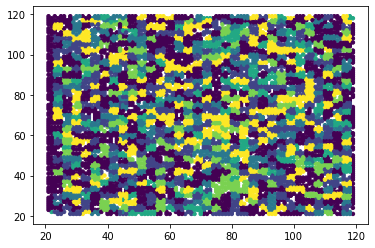

In [21]:
import matplotlib.pyplot as plt 

plt.scatter(x=old_cord[:,0],y=old_cord[:,1], c=band_values,s=12)

#### Bandwidth

#### Testing

In [6]:
%run GeoModel.ipynb

param = {'n_estimators': 200, 'max_features':3, 'max_depth': 5}


for row in tqdm(metadata.iloc[74:].iterrows(), total=len(metadata.iloc[74:])):

    # load data
    id_dataset = row[1]['id']

    features =  np.genfromtxt(f"data_features\\{row[1]['dataset_path']}", delimiter=',')
    labels = np.genfromtxt(f"data_labels\\{row[1]['target_path']}", delimiter=',')

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    c_train = X_train[:, -2:]
    c_test = X_test[:, -2:]

    X_train_nocoord = X_train[:, :-2]
    X_test_nocoord = X_test[:, :-2]
    

    limits_ind = [20,120,20,120]
    limits_indx = np.where((c_test[:,0] > limits_ind[0]) & (c_test[:,0] < limits_ind[1])
                            & (c_test[:,1] > limits_ind[2]) & (c_test[:,1] < limits_ind[3]))[0]
    
    c_test_limits = c_test[limits_indx]

    c_test_limits_sc = scaler(c_test_limits, -1, 1)
    
    X_test_nocoord_limits = X_test_nocoord[limits_indx]
    X_test_limits = np.hstack((X_test_nocoord_limits, c_test_limits_sc))

    bandwidth = np.genfromtxt(f'tuningRF\\bandwidth\\bandwidth_id_{id_dataset}.csv', delimiter=',')
    # get single bandwidth
    single_bandwidth = np.genfromtxt(f'tuningRF\\single_bandwidth\\single_bandwidth_id_{id_dataset}.csv', delimiter=',')
    single_bandwidth = int(single_bandwidth)

    # train and fit global model
    # with coordinates
    RF_coord = RandomForestRegressor(**param)
    RF_coord.fit(X_train, y_train)
    pred_RF_coord = RF_coord.predict(X_test_limits)
    
    # without coordinates
    param_coord =  {'n_estimators': 200, 'max_features':4, 'max_depth': 5}
    RF_g = RandomForestRegressor(**param_coord)
    RF_g.fit(X_train_nocoord, y_train)
    pred_RF = RF_g.predict(X_test_nocoord_limits)

    GRF = GeographicalModel('RandomForestRegressor', param, 'fixed', 'gaussian', [200])
    # local model
    # GRF
    GRF_pred = GRF.predict(single_bandwidth, 'fixed', 'linear', c_train, X_train_nocoord, y_train, c_test_limits, X_test_nocoord_limits, -2)

    # MSGRF
    MSGRF_pred = GRF.predict(bandwidth, 'fixed', 'linear', c_train, X_train_nocoord, y_train, c_test_limits, X_test_nocoord_limits, -2)

    # save results to csv 
    np.savetxt(f"testingRF\\RF_coord\\RF_coord_id_{id_dataset}.csv", pred_RF_coord, delimiter=",")
    np.savetxt(f"testingRF\\RF\\RF_id_{id_dataset}.csv", pred_RF, delimiter=",")
    np.savetxt(f"testingRF\\GRF\\GRF_id_{id_dataset}.csv", GRF_pred, delimiter=",")
    np.savetxt(f"testingRF\\MSGRF\\MSGRF_id_{id_dataset}.csv", MSGRF_pred, delimiter=",")